## Gradient Boosting-Inter

## 1. Importar paquetes y librerías

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error
from math import floor
import random
import Curva

#import seaborn as sns
#sns.set()

## 2. Importación de datos

In [109]:
loc=r"../interacciones_mensuales.csv"
data=pd.read_csv(loc,encoding="latin1",index_col=False,decimal=",",engine="python")
data = data.drop(data.columns[-20:], axis=1)

data=data[((data.Total-data.Total.mean()) / data.Total.std()).abs() <3]

X = data.drop(["Total","Month","Year","Cod",'P_days'],axis=1) # Asignar variables independientes
nombres = data.drop(["Total","Month","Year","Cod",'P_days'],axis=1).columns # Nombre de las variables dependientes
y = data['Total'] # Asignar variable dependiente

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Elección de parámetros

In [82]:
tuned_parameters = [{"learning_rate":[0.01,0.05,0.1],"n_estimators":[500,1000,2000],"subsample":[0.5,0.8,1],
                    "max_depth":[5,7,8,9]}]

for score in range(1):
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    model = GridSearchCV(ensemble.GradientBoostingRegressor(loss="ls"), tuned_parameters,cv=5,
                        scoring="neg_mean_squared_error")
    model.fit(X_train,y_train)

    print("Best parameters set found on development set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


## 3. Ajuste de modelos

### Ajuste y validación del modelo para cultivo completo

In [83]:
nEst = 500  # Número de estimadores
depth = 5
learnrate = 0.01
subSamp = 0.8

R2 = []
modelist = [0]
best_R = []
best_MAE = []
best_RMSE = []
best_CRM = []
pred=0
obs=0
m = []
error = [0]

X_Test = 0
y_Test = 0

for i in range(100):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) 
    
    cacaoGHModel = ensemble.GradientBoostingRegressor(n_estimators=nEst, max_depth=depth,
                                                 learning_rate=learnrate,subsample=subSamp, loss="ls")
    cacaoGHModel.fit(X_train,y_train)

    msError = []
    RMSE = []
    R_2 = []
    MAE = []
    CRM = []
    
    predictions = cacaoGHModel.staged_predict(X_test)
    for p in predictions:
        r2 = r2_score(y_test,p)
        R_2.append(r2)
        m.append(r2)
        RMSE.append(np.linalg.norm((y_test-p),2)/np.sqrt(len(y_test)))
        MAE.append(median_absolute_error(y_test,p))
        CRM.append((sum(y_test)-sum(p))/sum(y_test))
        msError.append(mean_squared_error(y_test,p))
        
        if r2 >= max(m):
            pred_co = p
            obs_co = y_test
            error = msError
            X_Test_co = X_test
            y_Test_co = y_test
            
            R2 = R_2
            modelist[0] = cacaoGHModel.feature_importances_
            model = cacaoGHModel
    
    best_R.append(max(R_2))
    best_MAE.append((MAE[R_2.index(max(R_2))],R_2.index(max(R_2))))
    best_RMSE.append((RMSE[R_2.index(max(R_2))],R_2.index(max(R_2))))
    best_CRM.append(CRM[R_2.index(max(R_2))])
    

In [84]:
# Valores medios para las métricas de ajuste

MAE = 0
RMSE = 0
for i in range(len(best_R)):
    MAE += best_MAE[i][0]
    RMSE += best_RMSE[i][0]

print("R^2 medio: %.4f" % (np.mean(best_R)))
print("RMSE medio: %.2f" % (RMSE/len(best_R)))
print("MAE medio: %.4f" % (MAE/len(best_R)))
print("CRM: %.4f" % (np.mean(best_CRM)))

R^2 medio: 0.5123
RMSE medio: 25.21
MAE medio: 12.9411
CRM: -0.0121


In [85]:
# Mejor desempeño

print("Mejor R: %.4f" % (max(best_R)))
print("Mejor RMSE: %.2f con %s arboles" % (best_RMSE[best_R.index(max(best_R))]))
print("Mejor MAE: %.2f con %s arboles" % (best_MAE[best_R.index(max(best_R))]))
print("Mejor CRM: %.4f" % (best_CRM[best_R.index(max(best_R))]))

Mejor R: 0.6709
Mejor RMSE: 19.95 con 451 arboles
Mejor MAE: 10.35 con 451 arboles
Mejor CRM: 0.0165


In [86]:
BEST_RMSE = round(best_RMSE[best_R.index(max(best_R))][0],2)
BEST_MAE = round(best_MAE[best_R.index(max(best_R))][0],2)

### Ajuste y evaluación gráfica del modelo

In [87]:
valores = [[round(max(best_R),2)],[BEST_RMSE],[BEST_MAE]]
label_row = ("$R^2$","RMSE","MAE")

<Figure size 432x288 with 0 Axes>

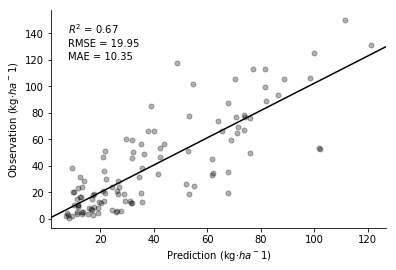

In [88]:
plt.figure("Diagrama de dispersión")
fig,ax=plt.subplots()

ax.scatter(pred_co,obs_co,s=100,alpha=0.3,c="black",marker=".")
ax.set_facecolor('white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

line_fit=sm.OLS(obs_co,sm.add_constant(pred_co,prepend=True)).fit()
abline_plot(model_results=line_fit,ax=ax,c="black")

plt.text(8,140,"$R^2$ = %.2f" % (max(best_R)))
plt.text(8,130,"RMSE = %.2f" % (BEST_RMSE))
plt.text(8,120,"MAE = %.2f" % (BEST_MAE))

plt.ylabel("Observation (kg$\cdot$$ha^-1$)")
plt.xlabel("Prediction (kg$\cdot$$ha^-1$)")
plt.savefig("Ajuste GB completo.jpg",dpi=600);

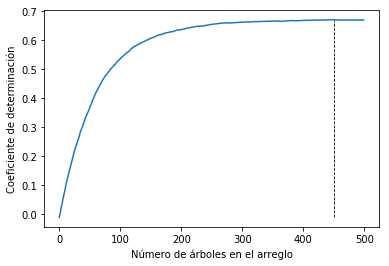

In [89]:
plt.plot(range(len(R2)), R2)
plt.vlines(R2.index(max(R2)),ymin=min(R2),ymax=max(R2),linestyle="--",linewidth=0.8)
plt.xlabel("Número de árboles en el arreglo")
plt.ylabel("Coeficiente de determinación")
plt.axis("tight")
#plt.text(nTreeList[R2.index(max(R2))] + 15,max(R2)-0.001,str((nTreeList[R2.index(max(R2))],round(max(R2),2))))
plt.savefig("Numero de arboles GB.jpg",dpi=600)
plt.show()

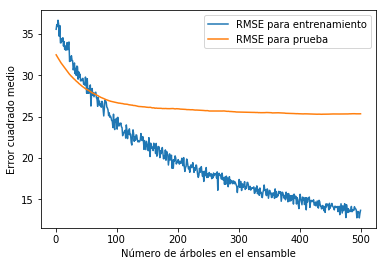

In [90]:
plt.figure()
plt.plot(range(1,nEst+1),np.sqrt(model.train_score_),label="RMSE para entrenamiento")
plt.plot(range(1,nEst+1),np.sqrt(msError),label="RMSE para prueba")
plt.legend()
plt.xlabel("Número de árboles en el ensamble")
plt.ylabel("Error cuadrado medio")
plt.savefig("Elección número de árboles GB1.jpg", dpi = 600);

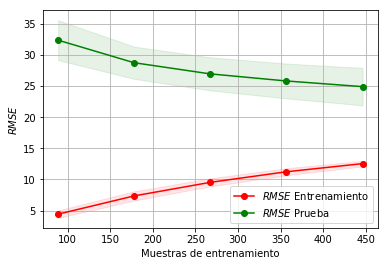

In [91]:
# Curva de aprendizaje

title = ""

cv = ShuffleSplit(n_splits=15, test_size = 0.2)
estimador = model
Curva.plot_learning_curve(estimador, title, X, y, cv = cv, n_jobs=4)
plt.savefig("Curva de aprendizaje GB.jpg", dpi =600);


## 4. Evaluación de variables

Se elimina una a una las variables para evaluar que tanto cambia el ajuste

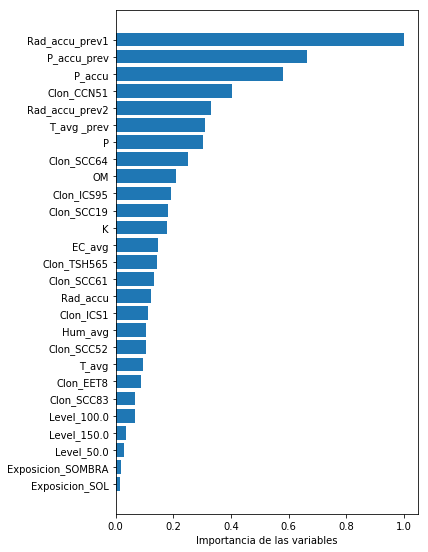

In [93]:
featureImportance = modelist[0]

featureImportance = featureImportance / featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(barPos, featureImportance[sorted_idx], align ="center")
plt.yticks(barPos,nombres[sorted_idx])
plt.xlabel("Importancia de las variables")
plt.subplots_adjust(left=0.2,right=0.9,top=1.8,bottom=0.05)
plt.savefig("Variables GB completo.jpg",dpi=600,bbox_inches="tight");

In [95]:
predictors = X_Test_co.columns

In [15]:
R_2_best = []
RMSE_best = []
MAE_best = []

for i in predictors:
    
    X = X_Test_co.copy()
    X[i] = 0
    
    R_2 = []
    RMSE = []
    MAE = []

    predictions = model.staged_predict(X)
    for p in predictions:
        r2 = r2_score(y_Test_co,p)
        R_2.append(r2)
        RMSE.append(np.linalg.norm((y_Test_co-p),2)/np.sqrt(len(y_Test_co)))
        MAE.append(median_absolute_error(y_Test_co,p))
    
    R_2_best.append(max(R_2))
    MAE_best.append((MAE[R_2.index(max(R_2))]))
    RMSE_best.append((RMSE[R_2.index(max(R_2))]))

In [16]:
A = pd.DataFrame([predictors,R_2_best, RMSE_best, MAE_best],index=["Variable","R","RMSE","MAE"]).T
A = A.sort_values(by = "RMSE",ascending = False)
A[["R","RMSE","MAE"]] = A[["R","RMSE","MAE"]].apply(pd.to_numeric) 
A.to_csv("Importancia variables completo.csv", decimal=",",index=False)
A

,Variable,R,RMSE,MAE
11,Rad_accu_prev1,0.117191,36.887600,13.401773
7,P_accu,0.338145,31.939534,12.768445
9,P_accu_prev,0.377702,30.970375,14.829626
10,T_avg _prev,0.564274,25.915155,12.890022
1,P,0.575508,25.578910,15.144195
12,Rad_accu_prev2,0.602763,24.744132,12.484108
19,Clon_SCC61,0.605580,24.656242,10.920242
3,OM,0.608430,24.566969,11.768515
13,Clon_CCN51,0.615527,24.343337,10.044614
4,Rad_accu,0.623764,24.081163,11.537296


## Alternativa - oscilaciones

In [17]:
var = ['T_avg','T_avg _prev',"P_accu", "P_accu_prev","Rad_accu","Rad_accu_prev1","Rad_accu_prev2","Hum_avg","EC_avg"]

In [18]:
#var = nombres

In [19]:
R_2_best = []
RMSE_best = []
MAE_best = []
pred_best = []
rango = []

for i in var:
    
    X = X_Test_co.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j

        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_co,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_co-p),2)/np.sqrt(len(y_Test_co)))
            MAE.append(median_absolute_error(y_Test_co,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
    
    rango.append(max(promedio)-min(promedio))

In [20]:
dic = {}

for i in var:
    if i not in dic:
        dic[i] = np.linspace(X_Test_co[i].min(), X_Test_co[i].max(),100)

RMSE_1 = RMSE_best[:100]
RMSE_2 = RMSE_best[100:200]
RMSE_3 = RMSE_best[200:300]
RMSE_4 = RMSE_best[300:400]
RMSE_5 = RMSE_best[400:500]
RMSE_6 = RMSE_best[500:600]
RMSE_7 = RMSE_best[600:700]
RMSE_8 = RMSE_best[-100:]

PRE_1 = pred_best[:100]
PRE_2 = pred_best[100:200]
PRE_3 = pred_best[200:300]
PRE_4 = pred_best[300:400]
PRE_5 = pred_best[400:500]
PRE_6 = pred_best[500:600]
PRE_7 = pred_best[600:700]
PRE_8 = pred_best[-100:]

In [21]:
pde = pd.DataFrame(dic)
pde["RMSE_1"],pde["RMSE_2"],pde["RMSE_3"],pde["RMSE_4"],pde["RMSE_5"],pde["RMSE_6"],pde["RMSE_7"],pde["RMSE_8"] = RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8
pde["PRE_1"],pde["PRE_2"],pde["PRE_3"],pde["PRE_4"],pde["PRE_5"],pde["PRE_6"],pde["PRE_7"],pde["PRE_8"] = PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8
#pde.to_csv("Evaluación.csv",decimal=",")

In [22]:
new_dic ={}
for i,j in enumerate(var):
    if j not in new_dic:
        new_dic[j]=round(rango[i]/sum(rango),2)

M = pd.DataFrame(new_dic,index=np.linspace(0,1,1)).T
M

,0.0
T_avg,0.01
T_avg _prev,0.09
P_accu,0.29
P_accu_prev,0.13
Rad_accu,0.02
Rad_accu_prev1,0.33
Rad_accu_prev2,0.10
Hum_avg,0.01
EC_avg,0.03


In [23]:
LASSO = pd.read_csv("Evaluación_lasso.csv",encoding="latin1",index_col=False,decimal=",",engine="python")
SVM = pd.read_csv("Evaluación_SVM.csv",encoding="latin1",index_col=False,decimal=",",engine="python")
RF = pd.read_csv("Evaluación_RF.csv",encoding="latin1",index_col=False,decimal=",",engine="python")
Arbol = pd.read_csv("Evaluación_arbol.csv",encoding="latin1",index_col=False,decimal=",",engine="python")

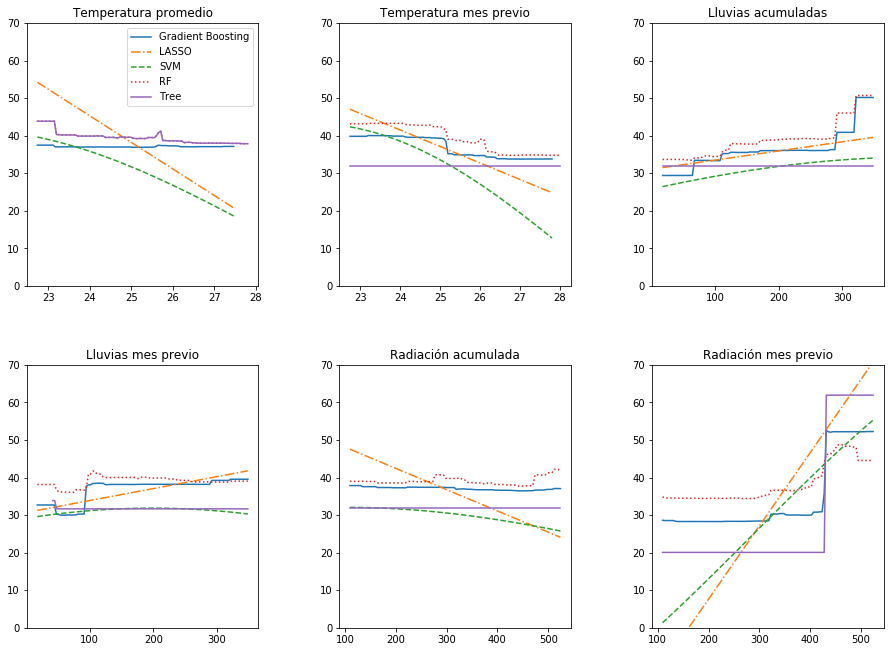

In [24]:
plt.figure(figsize=(14,10))

plt.subplot(2,3,1)
plt.ylim(0,70)
plt.title("Temperatura promedio")
plt.plot(pde.T_avg,pde.PRE_1, label = "Gradient Boosting",linestyle = "-")
plt.plot(pde.T_avg,LASSO.PRE_1, label = "LASSO",linestyle = "-.")
plt.plot(pde.T_avg,SVM.PRE_1, label = "SVM",linestyle = "--")
plt.plot(RF.T_avg,RF.PRE_1, label = "RF",linestyle = ":")
plt.plot(Arbol.T_avg,RF.PRE_1, label = "Tree",linestyle = "-")
plt.legend(prop={'size': 10})

plt.subplot(2,3,2)
plt.ylim(0,70)
plt.title("Temperatura mes previo")
plt.plot(pde['T_avg _prev'],pde.PRE_2)
plt.plot(pde['T_avg _prev'],LASSO.PRE_2, label = "LASSO",linestyle = "-.")
plt.plot(pde['T_avg _prev'],SVM.PRE_2, label = "SVM",linestyle = "--")
plt.plot(RF['T_avg _prev'],RF.PRE_2, label = "RF",linestyle = ":")
plt.plot(Arbol['T_avg _prev'],Arbol.PRE_2, label = "Tree",linestyle = "-")

plt.subplot(2,3,3)
plt.ylim(0,70)
plt.title("Lluvias acumuladas")
plt.plot(pde.P_accu,pde.PRE_3)
plt.plot(pde.P_accu,LASSO.PRE_3, label = "LASSO",linestyle = "-.")
plt.plot(pde.P_accu,SVM.PRE_3, label = "SVM",linestyle = "--")
plt.plot(RF.P_accu,RF.PRE_3, label = "RF",linestyle = ":")
plt.plot(Arbol.P_accu,Arbol.PRE_3, label = "Tree",linestyle = "-")


plt.subplot(2,3,4)
plt.ylim(0,70)
plt.title("Lluvias mes previo")
plt.plot(pde.P_accu_prev,pde.PRE_4)
plt.plot(pde.P_accu_prev,LASSO.PRE_4, label = "LASSO",linestyle = "-.")
plt.plot(pde.P_accu_prev,SVM.PRE_4, label = "SVM",linestyle = "--")
plt.plot(RF.P_accu_prev,RF.PRE_4, label = "RF",linestyle = ":")
plt.plot(Arbol.P_accu_prev,Arbol.PRE_4, label = "Tree",linestyle = "-")

plt.subplot(2,3,5)
plt.ylim(0,70)
plt.title("Radiación acumulada")
plt.plot(pde.Rad_accu,pde.PRE_5,label = "Gradient Boosting",linestyle = "-")
plt.plot(pde.Rad_accu,LASSO.PRE_5, label = "LASSO",linestyle = "-.")
plt.plot(pde.Rad_accu,SVM.PRE_5, label = "SVM",linestyle = "--")
plt.plot(RF.Rad_accu,RF.PRE_5, label = "RF",linestyle = ":")
plt.plot(Arbol.Rad_accu,Arbol.PRE_5, label = "Tree",linestyle = "-")

plt.subplot(2,3,6)
plt.ylim(0,70)
plt.title("Radiación mes previo")
plt.plot(pde.Rad_accu_prev1,pde.PRE_6)
plt.plot(pde.Rad_accu_prev1,LASSO.PRE_6, label = "LASSO",linestyle = "-.")
plt.plot(pde.Rad_accu_prev1,SVM.PRE_6, label = "SVM",linestyle = "--")
plt.plot(RF.Rad_accu_prev1,RF.PRE_6, label = "RF",linestyle = ":")
plt.plot(Arbol.Rad_accu_prev1,Arbol.PRE_6, label = "Tree",linestyle = "-")

plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,
                   hspace=0.3,wspace=0.35)

plt.savefig("Dependencias parciales_1.jpg",dpi = 600)

## Prueba con gráficos de depencia parcial en 3d

In [25]:
var = ['T_avg _prev',"P_accu","Rad_accu_prev1"]
y = y_Test

In [26]:
# Temperatura vs Radiación

R_2_best = []
RMSE_best = []
MAE_best = []
pred_best_1 = []
rango = []

x1 = []
x2 = []

for i in np.linspace(X_Test_co['T_avg _prev'].min(), X_Test_co['T_avg _prev'].max(),50):
    X = X_Test_co.copy()
    promedio = []
    
    for j in np.linspace(X["Rad_accu_prev1"].min(), X["Rad_accu_prev1"].max(),50):
        
        X[['T_avg _prev',"Rad_accu_prev1"]] = [i,j]
        
        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_co,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_co-p),2)/np.sqrt(len(y_Test_co)))
            MAE.append(median_absolute_error(y_Test_co,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best_1.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
        x2.append(j)
        x1.append(i)
    
    
    rango.append(max(promedio)-min(promedio))

In [27]:
# Temperatura vs Lluvias

R_2_best = []
RMSE_best = []
MAE_best = []
pred_best_2 = []
rango = []

x3 = []
x4 = []

for i in np.linspace(X_Test_co['T_avg _prev'].min(), X_Test_co['T_avg _prev'].max(),50):
    X = X_Test_co.copy()
    promedio = []
    
    for j in np.linspace(X["P_accu"].min(), X["P_accu"].max(),50):
        
        X[['T_avg _prev',"P_accu"]] = [i,j]
        
        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_co,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_co-p),2)/np.sqrt(len(y_Test_co)))
            MAE.append(median_absolute_error(y_Test_co,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best_2.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
        x4.append(j)
        x3.append(i)
    
    
    rango.append(max(promedio)-min(promedio))

In [28]:
# Lluvias vs radiación

R_2_best = []
RMSE_best = []
MAE_best = []
pred_best_3 = []
rango = []

x5 = []
x6 = []

for i in np.linspace(X_Test_co["Rad_accu_prev1"].min(), X_Test_co["Rad_accu_prev1"].max(),50):
    X = X_Test_co.copy()
    promedio = []
    
    for j in np.linspace(X["P_accu"].min(), X["P_accu"].max(),50):
        
        X[['T_avg _prev',"P_accu"]] = [i,j]
        
        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_co,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_co-p),2)/np.sqrt(len(y_Test_co)))
            MAE.append(median_absolute_error(y_Test_co,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best_3.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
        x6.append(j)
        x5.append(i)
    
    
    rango.append(max(promedio)-min(promedio))

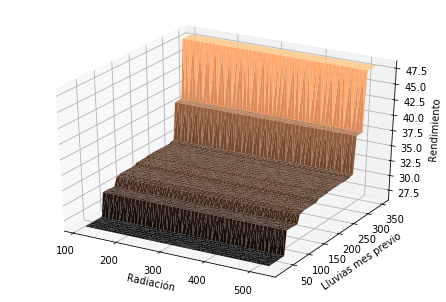

In [29]:
fig= plt.figure()
ax= Axes3D(fig)
fig.gca(projection='3d')
ax.plot_trisurf(x5, x6, pred_best_3, linewidth=0.2, antialiased=True, cmap='copper', edgecolor='none')

ax.set_xlabel('Radiación')
ax.set_ylabel('Lluvias mes previo')
ax.set_zlabel('Rendimiento')
plt.savefig("Dependencias radiación-lluvias.jpg",dpi = 600);

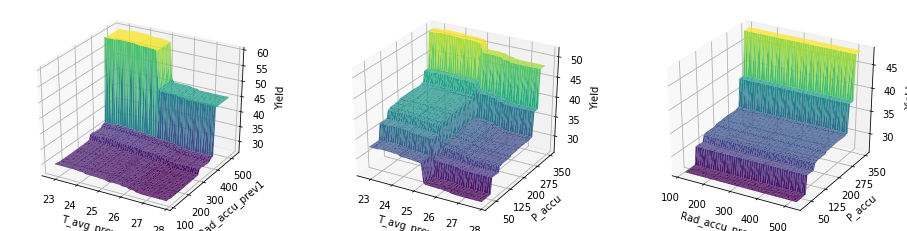

In [30]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.25))

#================
#  Primer gráfico
#================

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.plot_trisurf(x1, x2, pred_best_1, linewidth=0.2, antialiased=True, cmap='viridis', edgecolor='none')

ax.set_xlabel('T_avg_prev')
ax.set_ylabel('Rad_accu_prev1')
ax.set_zlabel('Yield')

#=================
# Segundo gráfico
#================
Array = np.linspace(50,350,5)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_trisurf(x3, x4, pred_best_2, linewidth=0.2, antialiased=True, cmap='viridis', edgecolor='none')

ax.set_xlabel('T_avg_prev',fontsize=10, rotation = 90)
ax.set_ylabel('P_accu')
ax.set_zlabel('Yield')
ax.set_yticks(Array)

#===============
# Tercer gráfico
#===============

Array = np.linspace(50,350,5)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot_trisurf(x5, x6, pred_best_3, linewidth=0.2, antialiased=True, cmap='viridis', edgecolor='none')

ax.set_xlabel('Rad_accu_prev1')
ax.set_ylabel('P_accu')
ax.set_zlabel('Yield', rotation=90)
ax.set_yticks(Array);

plt.savefig("Dependencias temperatura-radiación.jpg",dpi = 600);

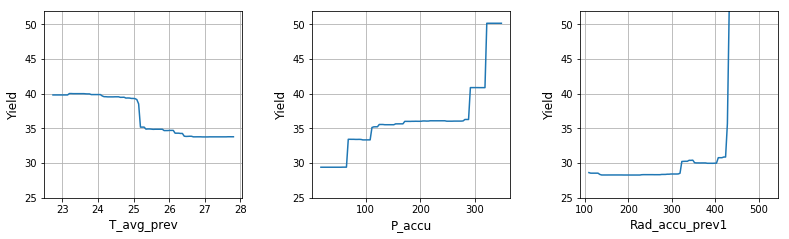

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.ylim(25,52)
plt.xlabel("T_avg_prev",fontsize=12)
plt.ylabel("Yield",fontsize=12)
plt.plot(pde['T_avg _prev'],pde.PRE_2)
plt.grid()

plt.subplot(1,3,2)
plt.ylim(25,52)
plt.xlabel("P_accu",fontsize=12)
plt.ylabel("Yield",fontsize=12)
plt.plot(pde.P_accu,pde.PRE_3)
plt.grid()

plt.subplot(1,3,3)
plt.ylim(25,52)
plt.ylabel("Yield",fontsize=12)
plt.xlabel("Rad_accu_prev1",fontsize=12)
plt.plot(pde.Rad_accu_prev1,pde.PRE_6)
plt.grid()

plt.subplots_adjust(top=0.8,bottom=0.15,left=0.1,right=0.95,
                   hspace=0.3,wspace=0.35)

plt.savefig("Dependencias parciales.jpg",dpi = 600)

## 6. Prueba para las mejores variables

### Este fragmento es utilizado para entrenar el modelo con las mejores variables identificadas y poder tomar la alternativa que posteriormente será usado en la aplicación web

In [112]:
X = data[['P_accu', 'T_avg _prev', 'Rad_accu_prev1']] # Asignar variables independientes
nombres = X.columns # Nombre de las variables dependientes
y = data['Total'] # Asignar variable dependiente

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [113]:
nEst = 500  # Número de estimadores
depth = 5
learnrate = 0.01
subSamp = 0.8

R2 = []
modelist = [0]
best_R = []
best_MAE = []
best_RMSE = []
best_CRM = []
pred=0
obs=0
m = []
error = [0]

X_Test = 0
y_Test = 0

for i in range(100):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) 
    
    cacaoGHModel = ensemble.GradientBoostingRegressor(n_estimators=nEst, max_depth=depth,
                                                 learning_rate=learnrate,subsample=subSamp, loss="ls")
    cacaoGHModel.fit(X_train,y_train)

    msError = []
    RMSE = []
    R_2 = []
    MAE = []
    CRM = []
    
    predictions = cacaoGHModel.staged_predict(X_test)
    for p in predictions:
        r2 = r2_score(y_test,p)
        R_2.append(r2)
        m.append(r2)
        RMSE.append(np.linalg.norm((y_test-p),2)/np.sqrt(len(y_test)))
        MAE.append(median_absolute_error(y_test,p))
        CRM.append((sum(y_test)-sum(p))/sum(y_test))
        msError.append(mean_squared_error(y_test,p))
        
        if r2 >= max(m):
            pred_co = p
            obs_co = y_test
            error = msError
            X_Test_co = X_test
            y_Test_co = y_test
            
            R2 = R_2
            modelist[0] = cacaoGHModel.feature_importances_
            model = cacaoGHModel
    
    best_R.append(max(R_2))
    best_MAE.append((MAE[R_2.index(max(R_2))],R_2.index(max(R_2))))
    best_RMSE.append((RMSE[R_2.index(max(R_2))],R_2.index(max(R_2))))
    best_CRM.append(CRM[R_2.index(max(R_2))])
    

In [114]:
# Mejor desempeño

print("Mejor R: %.4f" % (max(best_R)))
print("Mejor RMSE: %.2f con %s arboles" % (best_RMSE[best_R.index(max(best_R))]))
print("Mejor MAE: %.2f con %s arboles" % (best_MAE[best_R.index(max(best_R))]))
print("Mejor CRM: %.4f" % (best_CRM[best_R.index(max(best_R))]))

Mejor R: 0.6021
Mejor RMSE: 23.58 con 491 arboles
Mejor MAE: 13.60 con 491 arboles
Mejor CRM: 0.0415


In [115]:
import pickle

filename = "Modelo final.sav"
outfile = open(filename,"wb")
pickle.dump(model,outfile)
outfile.close()

# 7. Consideración por tipo de exposición

## Exposición bajo sol

Se toman las observaciones bajo sombra y se ignora la variable exposición solar

In [32]:
sombra = ["Total","Year","Cod",'P_days',"Exposicion_SOMBRA"]

In [33]:
X = data[data['Exposicion_SOL']==1]
y = X.Total
X = X.drop(sombra,1)

In [34]:
nEst = 500
depth = 5
learnrate = 0.01
subSamp = 0.8


R_2_sun = []
RMSE_sun = []
MAE_sun = []
CRM_sun = []
m = []
modelist_sun = [0]

X_Test = 0
y_Test = 0

for i in range(100):
    
        
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) # Hacer partición de datos en entrenamiento y prueba (80-20)
    
   
    cacaoGHModel = ensemble.GradientBoostingRegressor(n_estimators=nEst, max_depth=depth,
                                                 learning_rate=learnrate,subsample=subSamp, loss="ls")
    cacaoGHModel.fit(X_train,y_train)
    
    
    R_2 = []
    RMSE = []
    MAE = []
    CRM = []

    predictions = cacaoGHModel.staged_predict(X_test)
    for p in predictions:
        r2 = r2_score(y_test,p)
        R_2.append(r2)
        m.append(r2)
        RMSE.append(np.linalg.norm((y_test-p),2)/np.sqrt(len(y_test)))
        MAE.append(median_absolute_error(y_test,p))
        CRM.append((sum(y_test)-sum(p))/sum(y_test))
        
        if r2 >= max(m):
            modelist_sun[0] = cacaoGHModel.feature_importances_
            X_Test_sun = X_test
            y_Test_sun = y_test
            pred_sun = p
            model_sun = cacaoGHModel
            
    
    R_2_sun.append(max(R_2))
    RMSE_sun.append(RMSE[R_2.index(max(R_2))])
    MAE_sun.append(MAE[R_2.index(max(R_2))])
    CRM_sun.append(CRM[R_2.index(max(R_2))])
    

In [35]:
# Valores medios

print("R^2 medio: %.4f" % (np.mean(R_2_sun)))
print("RMSE medio: %.2f" % (np.mean(RMSE_sun)))
print("MAE medio: %.4f" % (np.mean(MAE_sun)))
print("CRM: %.4f" % (np.mean(CRM_sun)))

R^2 medio: 0.4546
RMSE medio: 24.80
MAE medio: 14.2026
CRM: -0.0222


In [36]:
# Mejor desempeño

print("Mejor R: %.4f" % (max(R_2_sun)))
print("Mejor RMSE: %.2f" % (RMSE_sun[R_2_sun.index(max(R_2_sun))]))
print("Mejor MAE: %.2f" % (MAE_sun[R_2_sun.index(max(R_2_sun))]))
print("Mejor CRM: %.2f" % (CRM_sun[R_2_sun.index(max(R_2_sun))]))

Mejor R: 0.6809
Mejor RMSE: 20.60
Mejor MAE: 13.26
Mejor CRM: -0.07


### Importancia de variables en sol

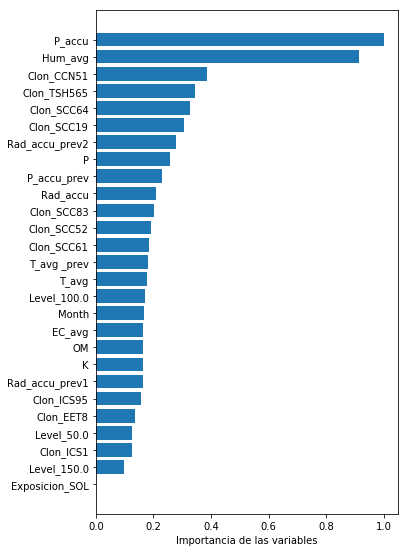

In [37]:
featureImportance = modelist_sun[0]

featureImportance = featureImportance / featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(barPos, featureImportance[sorted_idx], align ="center")
plt.yticks(barPos,nombres[sorted_idx])
plt.xlabel("Importancia de las variables")
plt.subplots_adjust(left=0.2,right=0.9,top=1.8,bottom=0.05)
plt.savefig("Variables GB sol.jpg",dpi=600,bbox_inches="tight");

## Oscilaciones para sol

In [38]:
var = X.columns

In [39]:
R_2_best = []
RMSE_best = []
MAE_best = []
pred_best = []
rango = []

for i in var:
    
    X = X_Test_sun.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j

        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model_sun.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_sun,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_sun-p),2)/np.sqrt(len(y_Test_sun)))
            MAE.append(median_absolute_error(y_Test_sun,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
    
    rango.append(max(promedio)-min(promedio))

In [40]:
new_dic ={}
for i,j in enumerate(var):
    if j not in new_dic:
        new_dic[j]=round(rango[i]/sum(rango),2)

pd.DataFrame(new_dic,index=np.linspace(0,1,1)).T


,0.0
Month,0.02
P,0.02
K,0.00
OM,0.01
Rad_accu,0.04
T_avg,0.02
EC_avg,0.01
P_accu,0.18
Hum_avg,0.14
P_accu_prev,0.02


In [41]:
predictors = X.columns

R_2_best = []
RMSE_best = []
MAE_best = []

for i in predictors:
    
    X = X_Test_sun.copy()
    X[i] = 0
    
    R_2 = []
    RMSE = []
    MAE = []

    predictions = model_sun.staged_predict(X)
    for p in predictions:
        r2 = r2_score(y_Test_sun,p)
        R_2.append(r2)
        RMSE.append(np.linalg.norm((y_Test_sun-p),2)/np.sqrt(len(y_Test_sun)))
        MAE.append(median_absolute_error(y_Test_sun,p))
    
    R_2_best.append(max(R_2))
    MAE_best.append((MAE[R_2.index(max(R_2))]))
    RMSE_best.append((RMSE[R_2.index(max(R_2))]))

In [42]:
A = pd.DataFrame([predictors,R_2_best, RMSE_best, MAE_best],index=["Variable","R","RMSE","MAE"]).T
A = A.sort_values(by = "RMSE",ascending = False)
A[["R","RMSE","MAE"]] = A[["R","RMSE","MAE"]].apply(pd.to_numeric)
A.to_csv("Importancia variables sol.csv", decimal=",")
A

,Variable,R,RMSE,MAE
8,Hum_avg,0.435183,27.408479,12.814987
7,P_accu,0.524226,25.155398,14.070927
13,Clon_CCN51,0.595899,23.183332,10.636916
20,Clon_SCC64,0.596193,23.174899,13.870372
12,Rad_accu_prev2,0.612452,22.703553,18.028560
4,Rad_accu,0.634489,22.048610,12.311274
5,T_avg,0.652242,21.506499,14.153005
16,Clon_ICS95,0.658777,21.303447,13.255971
19,Clon_SCC61,0.659098,21.293429,13.784072
9,P_accu_prev,0.659111,21.293013,13.870372


## Exposición bajo sombra

In [43]:
sol = ["Total","Year","Cod",'P_days',"Exposicion_SOL"]

In [44]:
X = data[data['Exposicion_SOMBRA']==1]
y = X.Total
X = X.drop(sol,1)
nombres = X.columns

In [45]:
nEst = 500  # Número de estimadores
depth = 5
learnrate = 0.01
subSamp = 0.8

R_2_shade = []
RMSE_shade = []
MAE_shade = []
CRM_shade = []
m = []
modelist_shade = [0]
obs = [0]
X_Test = 0
y_Test = 0

for i in range(100):
        
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2) # Hacer partición de datos en entrenamiento y prueba (80-20)
    
   
    cacaoGHModel = ensemble.GradientBoostingRegressor(n_estimators=nEst, max_depth=depth,
                                                 learning_rate=learnrate,subsample=subSamp, loss="ls")
    cacaoGHModel.fit(X_train,y_train)
    
    
    R_2 = []
    RMSE = []
    MAE = []
    CRM = []

    predictions = cacaoGHModel.staged_predict(X_test)
    for p in predictions:
        r2 = r2_score(y_test,p)
        R_2.append(r2)
        m.append(r2)
        RMSE.append(np.linalg.norm((y_test-p),2)/np.sqrt(len(y_test)))
        MAE.append(median_absolute_error(y_test,p))
        CRM.append((sum(y_test)-sum(p))/sum(y_test))
        
        
        if r2 >= max(m):
            modelist_shade[0] = cacaoGHModel.feature_importances_
            pred_shade = p
            obs[0] = (y_test)
            
            model_shade = cacaoGHModel
            X_Test_shade = X_test
            y_Test_shade = y_test            
    
    R_2_shade.append(max(R_2))
    RMSE_shade.append(RMSE[R_2.index(max(R_2))])
    MAE_shade.append(MAE[R_2.index(max(R_2))])
    CRM_shade.append(CRM[R_2.index(max(R_2))])
    

In [46]:
# Valores medios

print("R^2 medio: %.4f" % (np.mean(R_2_shade)))
print("RMSE medio: %.2f" % (np.mean(RMSE_shade)))
print("MAE medio: %.4f" % (np.mean(MAE_shade)))
print("CRM: %.4f" % (np.mean(CRM_shade)))

R^2 medio: 0.5374
RMSE medio: 24.97
MAE medio: 11.4201
CRM: -0.0320


In [47]:
# Mejor desempeño

print("Mejor R: %.4f" % (max(R_2_shade)))
print("Mejor RMSE: %.2f" % (RMSE_shade[R_2_shade.index(max(R_2_shade))]))
print("Mejor MAE: %.2f" % (MAE_shade[R_2_shade.index(max(R_2_shade))]))
print("Mejor CRM: %.2f" % (CRM_shade[R_2_shade.index(max(R_2_shade))]))

Mejor R: 0.8058
Mejor RMSE: 14.30
Mejor MAE: 7.33
Mejor CRM: -0.04


### Evaluación de variables

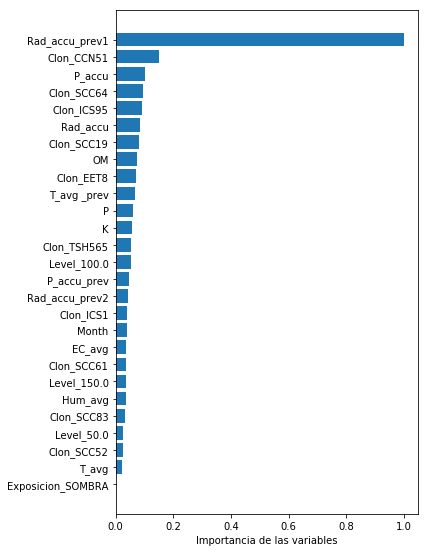

In [48]:
featureImportance = modelist_shade[0]

featureImportance = featureImportance / featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(barPos, featureImportance[sorted_idx], align ="center")
plt.yticks(barPos,nombres[sorted_idx])
plt.xlabel("Importancia de las variables")
plt.savefig("Variables GB sombra.jpg",dpi=600)

plt.subplots_adjust(left=0.2,right=0.9,top=1.8,bottom=0.05);

## Oscilación para sombra

In [49]:
var = X.columns

In [50]:
R_2_best = []
RMSE_best = []
MAE_best = []
pred_best = []
rango = []

for i in var:
    
    X = X_Test_shade.copy()
    promedio = []
    
    for j in np.linspace(X[i].min(), X[i].max(),100):
        
        X[i] = j

        R_2 = []
        RMSE = []
        MAE = []
        pred = []

        predictions = model_shade.staged_predict(X)
        for p in predictions:
            r2 = r2_score(y_Test_shade,p)
            R_2.append(r2)
            RMSE.append(np.linalg.norm((y_Test_shade-p),2)/np.sqrt(len(y_Test_shade)))
            MAE.append(median_absolute_error(y_Test_shade,p))
            pred.append(np.mean(p))

        promedio.append(np.mean(pred))
        pred_best.append(np.mean(pred))
        R_2_best.append(max(R_2))
        MAE_best.append((MAE[R_2.index(max(R_2))]))
        RMSE_best.append((RMSE[R_2.index(max(R_2))]))
    
    rango.append(max(promedio)-min(promedio))

In [51]:
new_dic ={}
for i,j in enumerate(var):
    if j not in new_dic:
        new_dic[j]=round(rango[i]/sum(rango),2)

pd.DataFrame(new_dic,index=np.linspace(0,1,1)).T

,0.0
Month,0.02
P,0.01
K,0.01
OM,0.01
Rad_accu,0.07
T_avg,0.00
EC_avg,0.03
P_accu,0.07
Hum_avg,0.01
P_accu_prev,0.04


In [52]:
predictors = X.columns

R_2_best = []
RMSE_best = []
MAE_best = []

for i in predictors:
    
    X = X_Test_shade.copy()
    X[i] = 0
    
    R_2 = []
    RMSE = []
    MAE = []

    predictions = model_shade.staged_predict(X)
    for p in predictions:
        r2 = r2_score(y_Test_shade,p)
        R_2.append(r2)
        RMSE.append(np.linalg.norm((y_Test_shade-p),2)/np.sqrt(len(y_Test_shade)))
        MAE.append(median_absolute_error(y_Test_shade,p))
    
    R_2_best.append(max(R_2))
    MAE_best.append((MAE[R_2.index(max(R_2))]))
    RMSE_best.append((RMSE[R_2.index(max(R_2))]))

In [53]:
A = pd.DataFrame([predictors,R_2_best, RMSE_best, MAE_best],index=["Variable","R","RMSE","MAE"]).T
A = A.sort_values(by = "RMSE",ascending = False)
A[["R","RMSE","MAE"]] = A[["R","RMSE","MAE"]].apply(pd.to_numeric)
A.to_csv("Importancia variables sombra.csv", decimal=",")
A

,Variable,R,RMSE,MAE
11,Rad_accu_prev1,0.011570,32.262857,17.627744
4,Rad_accu,0.595631,20.635675,13.626698
7,P_accu,0.631924,19.687854,6.556183
13,Clon_CCN51,0.714803,17.330145,7.640977
20,Clon_SCC64,0.763036,15.796870,7.930919
9,P_accu_prev,0.765912,15.700704,9.705682
15,Clon_ICS1,0.767983,15.631092,7.607604
1,P,0.787853,14.946805,8.219125
24,Level_100.0,0.789903,14.874423,8.050150
10,T_avg _prev,0.789985,14.871493,9.951090


## Comparación Sol-Sombra

In [54]:
BEST_RMSE_SUN = RMSE_sun[R_2_sun.index(max(R_2_sun))]
BEST_MAE_SUN = MAE_sun[R_2_sun.index(max(R_2_sun))]

BEST_RMSE_SHADE = RMSE_shade[R_2_shade.index(max(R_2_shade))]
BEST_MAE_SHADE = MAE_shade[R_2_shade.index(max(R_2_shade))]


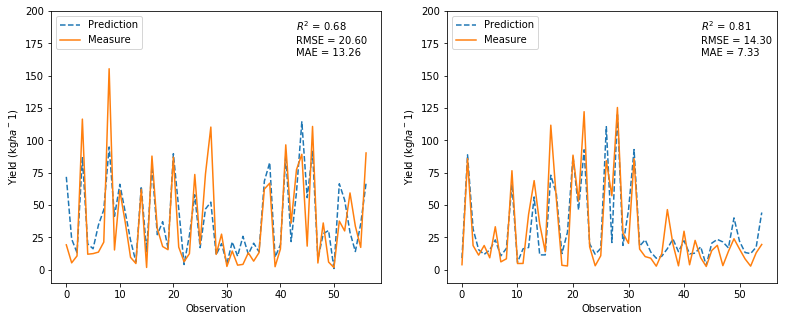

In [55]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)

#plt.title('(a)', y=-0.2)

plt.ylim([-10,200])
plt.plot(pred_sun, label = "Prediction",linestyle = "--")
plt.plot(list(y_Test_sun), label = "Measure")

plt.text(43,185,"$R^2$ = %.2f" % (max(R_2_sun)))
plt.text(43,175,"RMSE = %.2f" % (BEST_RMSE_SUN))
plt.text(43,165,"MAE = %.2f" % (BEST_MAE_SUN))

plt.ylabel("Yield (kg$ha^-1$)")
plt.xlabel("Observation")
plt.legend(loc = 2)

# SOMBRA

plt.subplot(1,2,2)

#plt.title('(b)', y=-0.2)

plt.ylim([-10,200])

plt.plot(pred_shade, label = "Prediction", linestyle="--")
plt.plot(list(y_Test_shade), label = "Measure")

plt.text(43,185,"$R^2$ = %.2f" % (max(R_2_shade)))
plt.text(43,175,"RMSE = %.2f" % (BEST_RMSE_SHADE))
plt.text(43,165,"MAE = %.2f" % (BEST_MAE_SHADE))

plt.ylabel("Yield (kg$ha^-1$)")
plt.xlabel("Observation")

plt.legend(loc = 2)

#plt.subplots_adjust(left=0.05,right=0.9,top=0.8,bottom=0.2)
#plt.savefig("Comparación sol_sombra.jpg",dpi =900);